In [1]:
import tweepy
import ast
import os
import re
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tweepy import OAuthHandler
from sklearn import svm 
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn import metrics

factory = StemmerFactory()
stemmer = factory.create_stemmer()
listStopword =  set(stopwords.words('indonesian'))  

In [2]:
df = pd.read_csv('stemming-semua.csv')
df

,Tweets,Case_Folding,Clean_Data,Tweet_Normal,Tanpa_StopWords,Stemming
0,shopeefood ini ga bisa ngasih tip buat driver ...,shopeefood ini ga bisa ngasih tip buat driver ...,shopeefood ini ga bisa ngasih tip buat driver ya,shopeefood ini tidak bisa memberi tip buat dri...,shopeefood tip driver,"['shopeefood', 'tip', 'driver']"
1,jangan ujan woyy shopeefood gua belom sampe 😭,jangan ujan woyy shopeefood gua belom sampe 😭,jangan ujan woyy shopeefood gua belom sampe,jangan hujan dong shopeefood saya belum sampai,hujan shopeefood,"['hujan', 'shopeefood']"
2,Gw masih kepikiran that random cheesecake I fo...,gw masih kepikiran that random cheesecake i fo...,gw masih kepikiran that random cheesecake i fo...,saya masih kepikiran that random cheesecake i ...,kepikiran random cheesecake found shopeefood,"['pikir', 'random', 'cheesecake', 'found', 'sh..."
3,@urlovelymeow Coba cek di shopeefood,@urlovelymeow coba cek di shopeefood,coba cek di shopeefood,coba cek di shopeefood,coba cek shopeefood,"['coba', 'cek', 'shopeefood']"
4,@wannayuuu @bdngfess Sok kirim aja kalo mau mh...,@wannayuuu @bdngfess sok kirim aja kalo mau mh...,sok kirim aja kalo mau mh seriusan ini tersera...,sok kirim aja kalau mau mah seriusan ini terse...,sok kirim mah seriusan terserah maunya grabfoo...,"['sok', 'kirim', 'mah', 'serius', 'serah', 'ma..."
...,...,...,...,...,...,...
5503,Makan Gratis Bareng Teman di ShopeeFood https:...,makan gratis bareng teman di shopeefood https:...,makan gratis bareng teman di shopeefood,makan gratis bersama teman di shopeefood,makan gratis teman shopeefood,"['makan', 'gratis', 'teman', 'shopeefood']"
5504,Geh! Aku mau daftarin ayahku di shopeefood as ...,geh! aku mau daftarin ayahku di shopeefood as ...,geh aku mau daftarin ayahku di shopeefood as d...,geh saya mau daftarin ayahku di shopeefood as ...,geh daftarin ayahku shopeefood driver daftarny...,"['geh', 'daftarin', 'ayah', 'shopeefood', 'dri..."
5505,alhamdulillah di rancaekek udh ada shopeefood,alhamdulillah di rancaekek udh ada shopeefood,alhamdulillah di rancaekek udh ada shopeefood,alhamdulillah di rancaekek sudah ada shopeefood,alhamdulillah rancaekek shopeefood,"['alhamdulillah', 'rancaekek', 'shopeefood']"
5506,Makan Gratis Bareng Teman di ShopeeFood https:...,makan gratis bareng teman di shopeefood https:...,makan gratis bareng teman di shopeefood,makan gratis bersama teman di shopeefood,makan gratis teman shopeefood,"['makan', 'gratis', 'teman', 'shopeefood']"


In [3]:
word_dict = {}
for i in range(0,len(df['Stemming'])):
    sentence = df['Stemming'][i]
    word_token = word_tokenize(sentence)
    for j in word_token:
        if j not in word_dict:
            word_dict[j] = 1
        else:
            word_dict[j] += 1

In [4]:
negasi = ['bukan','tidak','ga','gk']
lexicon = pd.read_csv('data_coba/full_lexicon.csv')
lexicon = lexicon.drop(lexicon[(lexicon['word'] == 'bukan')
                               |(lexicon['word'] == 'tidak')
                               |(lexicon['word'] == 'ga')|(lexicon['word'] == 'gk') ].index,axis=0)
lexicon = lexicon.reset_index(drop=True)

In [5]:
lexicon_word = lexicon['word'].to_list()
lexicon_num_words = lexicon['number_of_words']

ns_words = []

for word in word_dict.keys():
    if word not in lexicon_word:
        kata_dasar = stemmer.stem(word)
        if kata_dasar not in lexicon_word:
            ns_words.append(word)
len(ns_words)

5372

In [6]:
lexicon['number_of_words'].value_counts()

1    9544
2     684
3      26
4      25
5       5
Name: number_of_words, dtype: int64

In [7]:
sencol =[]
senrow =np.array([])
nsen = 0

sentiment_list = []
# function to write the word's sentiment if it is founded
def found_word(ind,words,word,sen,sencol,sentiment,add):
    # if it is already included in the bag of words matrix, then just increase the value
    if word in sencol:
        sen[sencol.index(word)] += 1
    else:
    #if not, than add new word
        sencol.append(word)
        sen.append(1)
        add += 1
    #if there is a negation word before it, the sentiment would be the negation of it's sentiment
    if (words[ind-1] in negasi):
        sentiment += -lexicon['weight'][lexicon_word.index(word)]
    else:
        sentiment += lexicon['weight'][lexicon_word.index(word)]
    
    return sen,sencol,sentiment,add
            
# checking every words, if they are appear in the lexicon, and then calculate their sentiment if they do
for i in range(len(df)):
    nsen = senrow.shape[0]
    words = word_tokenize(df['Stemming'][i])
    sentiment = 0 
    add = 0
    prev = [0 for ii in range(len(words))]
    n_words = len(words)
    if len(sencol)>0:
        sen =[0 for j in range(len(sencol))]
    else:
        sen =[]
    
    for word in words:
        ind = words.index(word)
        # check whether they are included in the lexicon
        if word in lexicon_word :
            sen,sencol,sentiment,add= found_word(ind,words,word,sen,sencol,sentiment,add)
        else:
        # if not, then check the root word
            kata_dasar = stemmer.stem(word)
            if kata_dasar in lexicon_word:
                sen,sencol,sentiment,add= found_word(ind,words,kata_dasar,sen,sencol,sentiment,add)
        # if still negative, try to match the combination of words with the adjacent words
            elif(n_words>1):
                if ind-1>-1:
                    back_1    = words[ind-1]+' '+word
                    if (back_1 in lexicon_word):
                        sen,sencol,sentiment,add= found_word(ind,words,back_1,sen,sencol,sentiment,add)
                    elif(ind-2>-1):
                        back_2    = words[ind-2]+' '+back_1
                        if back_2 in lexicon_word:
                            sen,sencol,sentiment,add= found_word(ind,words,back_2,sen,sencol,sentiment,add)
    # if there is new word founded, then expand the matrix
    if add>0:  
        if i>0:
            if (nsen==0):
                senrow = np.zeros([i,add],dtype=int)
            elif(i!=nsen):
                padding_h = np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding_h))
                padding_v = np.zeros([(i-nsen),senrow.shape[1]],dtype=int)
                senrow = np.vstack((senrow,padding_v))
            else:
                padding =np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding))
            senrow = np.vstack((senrow,sen))
        if i==0:
            senrow = np.array(sen).reshape(1,len(sen))
    # if there isn't then just update the old matrix
    elif(nsen>0):
        senrow = np.vstack((senrow,sen))
        
    sentiment_list.append(sentiment)

In [8]:
sencol.append('Bobot')
sentiment_array = np.array(sentiment_list).reshape(senrow.shape[0],1)
sentiment_data = np.hstack((senrow,sentiment_array))
df_sen = pd.DataFrame(sentiment_data,columns = sencol)

In [9]:
df_sen

,tip,hujan,pikir,random,coba,cek,kirim,serius,serah,mau,...,ingat,man,nyinyir,genap,simak,tukar,suudzon,gengsi,tetiba,Bobot
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-3
3,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-2
4,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
5504,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
5505,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
5506,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [10]:
cek_df = pd.DataFrame([])
cek_df['Tweetnya'] = df['Stemming'].copy()
cek_df['Bobot']  = df_sen['Bobot'].copy()

cek_df

,Tweetnya,Bobot
0,"['shopeefood', 'tip', 'driver']",4
1,"['hujan', 'shopeefood']",1
2,"['pikir', 'random', 'cheesecake', 'found', 'sh...",-3
3,"['coba', 'cek', 'shopeefood']",-2
4,"['sok', 'kirim', 'mah', 'serius', 'serah', 'ma...",4
...,...,...
5503,"['makan', 'gratis', 'teman', 'shopeefood']",5
5504,"['geh', 'daftarin', 'ayah', 'shopeefood', 'dri...",11
5505,"['alhamdulillah', 'rancaekek', 'shopeefood']",5
5506,"['makan', 'gratis', 'teman', 'shopeefood']",5


In [11]:
def repair_exaggeration(x):
    word_tokens = word_tokenize(x)
    new_x =''
    for i in word_tokens:
        if (i =='woyy'):
            new = re.sub(r'(\w)\1\1+',r'\1\1',i)
            new_x = new_x +new+' '
        elif(i =='woy'):
            new = 'woy'
            new_x = new_x +new+' '
        else:
            new = re.sub(r'(\w)\1\1\1+',r'\1',i)
            new_x = new_x +new+' '
    return new_x

def del_word(x,key_list):
    n = len(key_list)
    word_tokens = word_tokenize(x)
    new_x =''
    for word in word_tokens:
        if word not in key_list:
            new_x = new_x+word+' '
    return new_x

In [15]:
clean_text = df['Clean_Data'].copy()
clean_text_exag = clean_text.apply(lambda x: repair_exaggeration(x))

In [16]:
clean_text_exag

0                              shopeefood ga tip driver 
1                                  ujan woyy shopeefood 
2      terpikirkan that random cheesecake i found on ...
3                                   coba cek shopeefood 
4      sok kirim mh seriusan terserah maunya grabfood...
                             ...                        
690    ramaikan pengen banget punyaiphone c logo mura...
691    ramaikan pengen banget punyaiphone c logo mura...
692    ramaikan pengen banget punyaiphone c logo mura...
693    ramaikan pengen banget punyaiphone c logo mura...
694    ramaikan pengen banget punyaiphone c logo mura...
Name: Clean_Data, Length: 695, dtype: object

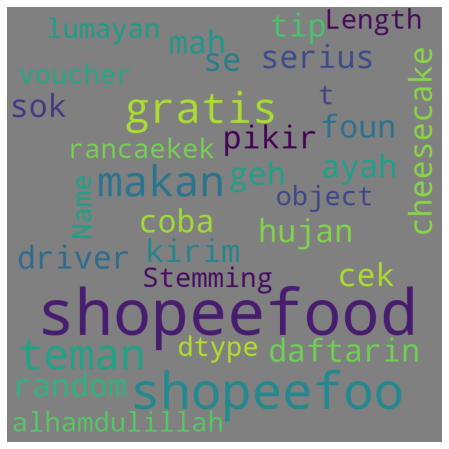

In [12]:
word_to_plot = df['Stemming'].copy()
word_to_plot_1 = word_to_plot.apply(lambda x: del_word(x,negasi))

wordcloud = WordCloud(width = 800, height = 800, background_color = 'gray', max_words = 1000
                      , min_font_size = 20).generate(str(word_to_plot_1))
#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Text(0.5, 0, 'Sentiment')

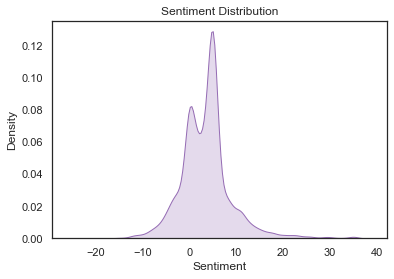

In [14]:
sns.set(style="white", palette="muted", color_codes=True)
sns.kdeplot(df_sen['Bobot'],color='m',shade=True)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')

<AxesSubplot:xlabel='Sentiment'>

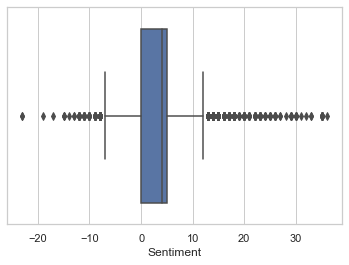

In [19]:
sns.set(style="whitegrid") 
sns.boxplot(x=df_sen['Sentiment'])

In [15]:
df_sen.describe()

,tip,hujan,pikir,random,coba,cek,kirim,serius,serah,mau,...,ingat,man,nyinyir,genap,simak,tukar,suudzon,gengsi,tetiba,Bobot
count,5508.000000,5508.000000,5508.000000,5508.000000,5508.000000,5508.00000,5508.000000,5508.000000,5508.000000,5508.000000,...,5508.000000,5508.000000,5508.000000,5508.000000,5508.000000,5508.000000,5508.000000,5508.000000,5508.000000,5508.000000
mean,0.004539,0.023239,0.004176,0.001634,0.019971,0.03032,0.010530,0.001816,0.001452,0.001089,...,0.000182,0.000182,0.000182,0.000182,0.000182,0.000182,0.000182,0.000182,0.000182,3.582970
std,0.072425,0.176227,0.067248,0.040393,0.146258,0.18076,0.115441,0.042574,0.038087,0.032990,...,0.013474,0.013474,0.013474,0.013474,0.013474,0.013474,0.013474,0.013474,0.013474,5.602748
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-23.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
max,2.000000,4.000000,2.000000,1.000000,2.000000,3.00000,3.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,36.000000


In [21]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=10):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

#print("Top Absolute Correlations")
#print(get_top_abs_correlations(df_sen, 10))
au = get_top_abs_correlations(df_sen, 15)

print('Perfect Correlation')
au[au==1]

Perfect Correlation


gari       repot         1.0
hantu      rintis        1.0
sampah     sungkan       1.0
laba       utang         1.0
bekal      jatah         1.0
lemes      idk           1.0
mara       protes        1.0
eksklusif  rangkai       1.0
kampanye   rangkai       1.0
           eksklusif     1.0
idam       asam          1.0
           hujung        1.0
maafin     maapin        1.0
asam       hujung        1.0
umat       repot         1.0
faktor     tingkat       1.0
badmood    ain           1.0
detektif   mungil        1.0
faktor     koneksi       1.0
tingkat    koneksi       1.0
nemenin    batu          1.0
kapal      api           1.0
bisnis     merger        1.0
singgah    sebentar      1.0
nabi       eka           1.0
harum      keki          1.0
cengger    ragu          1.0
kapal      tengah        1.0
kencan     gemuk         1.0
pasuk      harus         1.0
umat       gari          1.0
ingat      man           1.0
antem      majikan       1.0
lezat      tanding       1.0
cemas      cab

In [16]:
df['Bobot'] = df_sen['Bobot']
df

,Tweets,Case_Folding,Clean_Data,Tweet_Normal,Tanpa_StopWords,Stemming,Bobot
0,shopeefood ini ga bisa ngasih tip buat driver ...,shopeefood ini ga bisa ngasih tip buat driver ...,shopeefood ini ga bisa ngasih tip buat driver ya,shopeefood ini tidak bisa memberi tip buat dri...,shopeefood tip driver,"['shopeefood', 'tip', 'driver']",4
1,jangan ujan woyy shopeefood gua belom sampe 😭,jangan ujan woyy shopeefood gua belom sampe 😭,jangan ujan woyy shopeefood gua belom sampe,jangan hujan dong shopeefood saya belum sampai,hujan shopeefood,"['hujan', 'shopeefood']",1
2,Gw masih kepikiran that random cheesecake I fo...,gw masih kepikiran that random cheesecake i fo...,gw masih kepikiran that random cheesecake i fo...,saya masih kepikiran that random cheesecake i ...,kepikiran random cheesecake found shopeefood,"['pikir', 'random', 'cheesecake', 'found', 'sh...",-3
3,@urlovelymeow Coba cek di shopeefood,@urlovelymeow coba cek di shopeefood,coba cek di shopeefood,coba cek di shopeefood,coba cek shopeefood,"['coba', 'cek', 'shopeefood']",-2
4,@wannayuuu @bdngfess Sok kirim aja kalo mau mh...,@wannayuuu @bdngfess sok kirim aja kalo mau mh...,sok kirim aja kalo mau mh seriusan ini tersera...,sok kirim aja kalau mau mah seriusan ini terse...,sok kirim mah seriusan terserah maunya grabfoo...,"['sok', 'kirim', 'mah', 'serius', 'serah', 'ma...",4
...,...,...,...,...,...,...,...
5503,Makan Gratis Bareng Teman di ShopeeFood https:...,makan gratis bareng teman di shopeefood https:...,makan gratis bareng teman di shopeefood,makan gratis bersama teman di shopeefood,makan gratis teman shopeefood,"['makan', 'gratis', 'teman', 'shopeefood']",5
5504,Geh! Aku mau daftarin ayahku di shopeefood as ...,geh! aku mau daftarin ayahku di shopeefood as ...,geh aku mau daftarin ayahku di shopeefood as d...,geh saya mau daftarin ayahku di shopeefood as ...,geh daftarin ayahku shopeefood driver daftarny...,"['geh', 'daftarin', 'ayah', 'shopeefood', 'dri...",11
5505,alhamdulillah di rancaekek udh ada shopeefood,alhamdulillah di rancaekek udh ada shopeefood,alhamdulillah di rancaekek udh ada shopeefood,alhamdulillah di rancaekek sudah ada shopeefood,alhamdulillah rancaekek shopeefood,"['alhamdulillah', 'rancaekek', 'shopeefood']",5
5506,Makan Gratis Bareng Teman di ShopeeFood https:...,makan gratis bareng teman di shopeefood https:...,makan gratis bareng teman di shopeefood,makan gratis bersama teman di shopeefood,makan gratis teman shopeefood,"['makan', 'gratis', 'teman', 'shopeefood']",5


In [17]:
df.loc[df['Bobot'] == 0, 'Label'] = 'netral'
df.loc[df['Bobot'] > 0, 'Label'] = 'positif'
df.loc[df['Bobot'] < 0, 'Label'] = 'negatif'
df['Label'].value_counts()

positif    3899
negatif     852
netral      757
Name: Label, dtype: int64

In [18]:
df.loc[cek_df['Bobot'] == 0, 'Sentiment'] = 1 #netral
df.loc[cek_df['Bobot'] > 0, 'Sentiment'] = 2 #positif
df.loc[cek_df['Bobot'] < 0, 'Sentiment'] = 0 #negatif

In [19]:
df

,Tweets,Case_Folding,Clean_Data,Tweet_Normal,Tanpa_StopWords,Stemming,Bobot,Label,Sentiment
0,shopeefood ini ga bisa ngasih tip buat driver ...,shopeefood ini ga bisa ngasih tip buat driver ...,shopeefood ini ga bisa ngasih tip buat driver ya,shopeefood ini tidak bisa memberi tip buat dri...,shopeefood tip driver,"['shopeefood', 'tip', 'driver']",4,positif,2.0
1,jangan ujan woyy shopeefood gua belom sampe 😭,jangan ujan woyy shopeefood gua belom sampe 😭,jangan ujan woyy shopeefood gua belom sampe,jangan hujan dong shopeefood saya belum sampai,hujan shopeefood,"['hujan', 'shopeefood']",1,positif,2.0
2,Gw masih kepikiran that random cheesecake I fo...,gw masih kepikiran that random cheesecake i fo...,gw masih kepikiran that random cheesecake i fo...,saya masih kepikiran that random cheesecake i ...,kepikiran random cheesecake found shopeefood,"['pikir', 'random', 'cheesecake', 'found', 'sh...",-3,negatif,0.0
3,@urlovelymeow Coba cek di shopeefood,@urlovelymeow coba cek di shopeefood,coba cek di shopeefood,coba cek di shopeefood,coba cek shopeefood,"['coba', 'cek', 'shopeefood']",-2,negatif,0.0
4,@wannayuuu @bdngfess Sok kirim aja kalo mau mh...,@wannayuuu @bdngfess sok kirim aja kalo mau mh...,sok kirim aja kalo mau mh seriusan ini tersera...,sok kirim aja kalau mau mah seriusan ini terse...,sok kirim mah seriusan terserah maunya grabfoo...,"['sok', 'kirim', 'mah', 'serius', 'serah', 'ma...",4,positif,2.0
...,...,...,...,...,...,...,...,...,...
5503,Makan Gratis Bareng Teman di ShopeeFood https:...,makan gratis bareng teman di shopeefood https:...,makan gratis bareng teman di shopeefood,makan gratis bersama teman di shopeefood,makan gratis teman shopeefood,"['makan', 'gratis', 'teman', 'shopeefood']",5,positif,2.0
5504,Geh! Aku mau daftarin ayahku di shopeefood as ...,geh! aku mau daftarin ayahku di shopeefood as ...,geh aku mau daftarin ayahku di shopeefood as d...,geh saya mau daftarin ayahku di shopeefood as ...,geh daftarin ayahku shopeefood driver daftarny...,"['geh', 'daftarin', 'ayah', 'shopeefood', 'dri...",11,positif,2.0
5505,alhamdulillah di rancaekek udh ada shopeefood,alhamdulillah di rancaekek udh ada shopeefood,alhamdulillah di rancaekek udh ada shopeefood,alhamdulillah di rancaekek sudah ada shopeefood,alhamdulillah rancaekek shopeefood,"['alhamdulillah', 'rancaekek', 'shopeefood']",5,positif,2.0
5506,Makan Gratis Bareng Teman di ShopeeFood https:...,makan gratis bareng teman di shopeefood https:...,makan gratis bareng teman di shopeefood,makan gratis bersama teman di shopeefood,makan gratis teman shopeefood,"['makan', 'gratis', 'teman', 'shopeefood']",5,positif,2.0


In [20]:
df.to_csv('lexicon-oke.csv')

In [2]:
df = pd.read_csv('hasilnya.csv')